### Attention of TanhMax

In [1]:
import pandas as pd
import torch.utils.data as Data
import torch.optim as optim
from torch.autograd import Variable
import torch
from torch import optim
import torch.nn as nn
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
from model import generate_synthetic_data
text_length = 12
batch_size = 100
vocab_size = 2000
epoch_num = 1
data,labels,Pos,Neg,Neu = generate_synthetic_data(datasize=10000,vocab_size=vocab_size,polarity_size=200)
print(len(data),len(labels))

10000 10000


In [3]:
from model import MyDataSet
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=42)

batch = Variable(torch.LongTensor(X_train))
labels = Variable(torch.LongTensor(y_train))
loader = Data.DataLoader(MyDataSet(batch,labels), batch_size, True)

In [4]:
#from model import SelfAttnClassifier

def TanhMax(a):
    return (torch.exp(a) - torch.exp(-a)) / (torch.exp(a) + torch.exp(-a)).sum(dim=-1).unsqueeze(dim=-1)
    
class SelfAttnClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim=1, scale=1,score_function='dot', activation='TanhMax'):
        super(SelfAttnClassifier, self).__init__()
        
        self.embeddings = nn.Embedding(vocab_size, embed_dim)
        self.embeddings.weight.data.uniform_(-0.1, 0.1)
        self.scale = scale
        self.Wk = nn.Linear(embed_dim,hidden_dim)
        self.Wv = nn.Linear(embed_dim,hidden_dim)
        self.Wq = nn.Linear(embed_dim,hidden_dim)
        self.score_function = score_function
        if self.score_function == 'additive':
            self.v = nn.Parameter(torch.randn(hidden_dim, 1))
        
        if activation.lower() == 'softmax':
            self.activate = nn.Softmax(dim=-1)
        elif activation.lower() == 'tanhmax':
            self.activate = TanhMax
        elif activation.lower() == 'tanh':
            self.activate = nn.Tanh()
        
        self.dropout = nn.Dropout(0.5)
        self.dense = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()
        

    # batch_size * sent_l * dim
    def forward(self, seq_ids, labels=None):
        seq_embs = self.embeddings(seq_ids)
        
        Q = self.Wq(seq_embs)
        K = self.Wk(seq_embs)
        V = self.Wv(seq_embs)
        
        if self.score_function == 'dot':
            scores = (Q*K).sum(dim=-1) / self.scale
        elif self.score_function == 'additive':
            scores = torch.matmul(nn.Tanh()(K+Q),self.v).squeeze(-1)
        #print(scores.shape,V.shape)
            
        if labels is None:
            scores = scores 
        else:
            scores = scores * labels.unsqueeze(dim=-1)
            
        attn = self.activate(scores)
        #print(attn.shape)
        final_vec = torch.bmm(attn.unsqueeze(1), V).squeeze(1)
        senti_scores = self.dense(self.dropout(final_vec))
        probs = self.sigmoid(senti_scores)
        return probs

loss_function = nn.BCELoss()
model = SelfAttnClassifier(vocab_size+1, 30, 10, 1, scale=3.0, score_function='additive',activation='TanhMax')
optimizer = torch.optim.Adadelta(model.parameters(), lr=0.05)

use_gpu = torch.cuda.is_available()

if(use_gpu):
    model = model.cuda()
    loss_function = loss_function.cuda()

In [5]:
model.train()
for epoch in tqdm(range(100)):
    for input_ids, label in loader:
        model.zero_grad()
        preds = model(input_ids.cuda())
        loss = loss_function(preds.squeeze(), label.cuda().float()) * 100
        loss.backward(retain_graph=True)
        optimizer.step()
        input_ids.cpu()
        label.cpu()

100%|██████████| 100/100 [00:44<00:00,  2.23it/s]


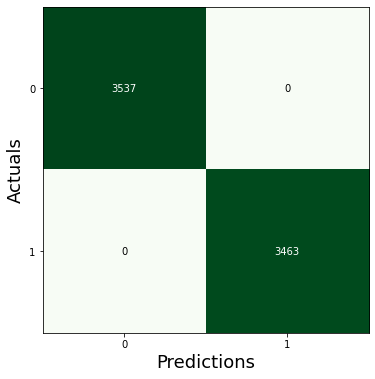

accuracy:100.000%


In [6]:
from model import plot_cm_matrix
plot_cm_matrix(model,batch,labels,save_url='graph/metric/TanhMaxTrainAcc.png')

### test accuracy

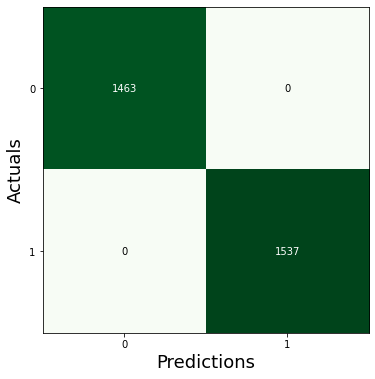

accuracy:100.000%


In [7]:
test_batch = Variable(torch.LongTensor(X_test))
test_labels = Variable(torch.LongTensor(y_test))
plot_cm_matrix(model,test_batch,test_labels,save_url='graph/metric/picture6.png')

### Save Model

In [8]:
## 保存
torch.save(model.state_dict(), 'model/TanhMaxParameter.pkl')
torch.save(model, 'model/TanhMaxModel.pkl')

## 加载
#model = SelfAttnClassifier(vocab_size+1, 30, 10, 1, scale=5.0,score_function='dot',activation='SoftMax')
#model.load_state_dict(torch.load('model/SoftmaxParameter.pkl'))

# 加载
#model = torch.load('model/SoftmaxModel.pkl')

### Visualization

In [9]:
from model import compute_coefficients
pos_index,pos_score,pos_weight,neg_index,neg_score,neg_weight,neutral_index,neutral_score,neutral_weight = compute_coefficients(model,batch,Pos,Neg,Neu)

Pos Mean: 10.71776479959488 Pos Std: 2.5802264709478395
Neg Mean: -8.05431408882141 Neg Std: 2.6168231149926124
Neu Mean: -1.1706505846170088 Neu Std: 0.8728716775139623


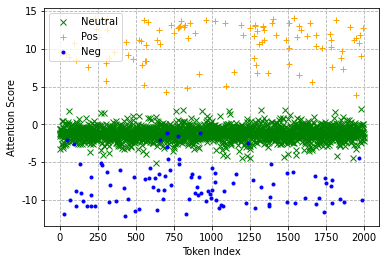

In [10]:
plt.rcParams['axes.unicode_minus'] = False
plt.plot(neutral_index, neutral_score, 'x', label='Neutral',color='green')
plt.plot(pos_index, pos_score, '+',label='Pos',color='orange')
plt.plot(neg_index, neg_score, '.', label='Neg',color='blue')
plt.xlabel('Token Index')
plt.ylabel('Attention Score')
plt.grid(linestyle='--')
plt.legend()
plt.savefig('graph/metric/picture4.png')
print('Pos Mean:',np.mean(pos_score),'Pos Std:',np.std(pos_score))
print('Neg Mean:',np.mean(neg_score),'Neg Std:',np.std(neg_score))
print('Neu Mean:',np.mean(neutral_score),'Neu Std:',np.std(neutral_score))

Pos Mean: 0.48677578547070366 Pos Std: 0.26845358415461146
Neg Mean: -0.47716530520205735 Neg Std: 0.2718285113803442
Neu Mean: -0.0008015545336732113 Neu Std: 0.0020860193691767115


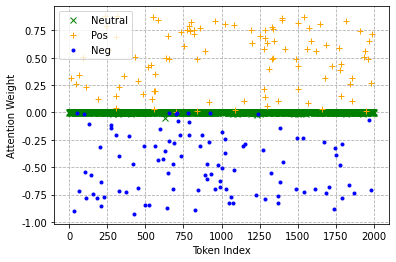

In [11]:
plt.rcParams['axes.unicode_minus'] = False
plt.plot(neutral_index, neutral_weight, 'x', label='Neutral',color='green')
plt.plot(pos_index, pos_weight, '+',label='Pos',color='orange')
plt.plot(neg_index, neg_weight, '.', label='Neg',color='blue')
plt.xlabel('Token Index')
plt.ylabel('Attention Weight')
plt.grid(linestyle='--')
plt.legend()
plt.savefig('graph/metric/picture5.png')
print('Pos Mean:',np.mean(pos_weight),'Pos Std:',np.std(pos_weight))
print('Neg Mean:',np.mean(neg_weight),'Neg Std:',np.std(neg_weight))
print('Neu Mean:',np.mean(neutral_weight),'Neu Std:',np.std(neutral_weight))

### Exp1 -- Gradient Importance

3000it [00:05, 552.75it/s]


Both label
	p-value < 0.05: 1121  ratio: 0.37366666666666665
	p-value < 0.01: 455  ratio: 0.15166666666666667
	Both-Mean: 0.3777565705128204 Std: 0.17727671118989957

Pos
	p-value < 0.05: 612  ratio: 0.39817826935588807
	p-value < 0.01: 257  ratio: 0.16720884840598568
	Pos-Mean: 0.3895330867354289 Std: 0.17570630973020843

Neg
	p-value < 0.05: 509  ratio: 0.34791524265208473
	p-value < 0.01: 198  ratio: 0.13533834586466165
	Neg-Mean: 0.365384386347305 Std: 0.17807476948554377


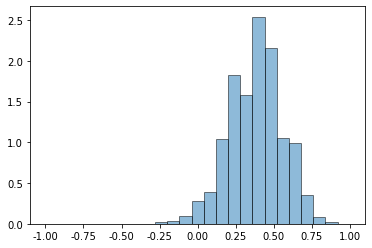

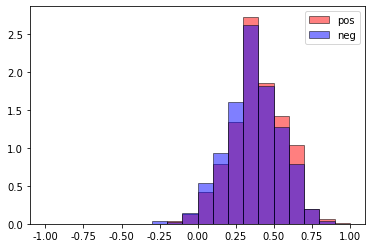

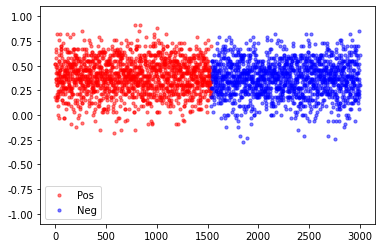

In [12]:
from model import GradientImportance
GradientImportance(model,test_batch,test_labels,'TanhMax')

### Exp2--Feature Erasure

3000it [00:14, 204.97it/s]


Both label
	p-value < 0.05: 3000  ratio: 1.0
	p-value < 0.01: 3000  ratio: 1.0
	total num: 3000  mean: 0.9429339469012946  std: 0.04682642350016913
Pos
	p-value < 0.05: 1537  ratio: 1.0
	p-value < 0.01: 1537  ratio: 1.0
	total num: 1537  mean: 0.9438199896715416  std: 0.04599540069324719
Neg
	p-value < 0.05: 1463  ratio: 1.0
	p-value < 0.01: 1463  ratio: 1.0
	total num: 1463  mean: 0.9420030872035027  std: 0.04766614499341744


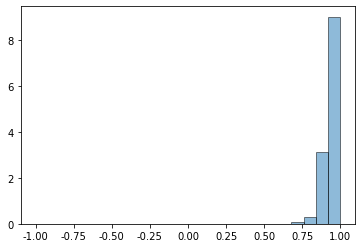

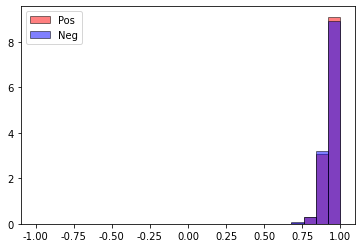

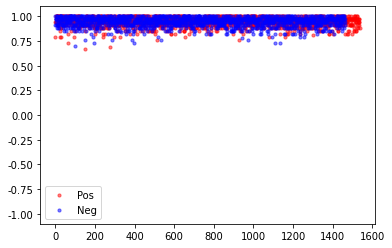

In [13]:
from model import FeatureErasure
FeatureErasure(model,test_batch,test_labels,'TanhMax')

### Exp3--Feature Erasure ABS

3000it [00:15, 190.99it/s]


Both label
	p-value < 0.05: 3000  ratio: 1.0
	p-value < 0.01: 3000  ratio: 1.0
	total num: 3000  mean: 0.9407658647287678  std: 0.04739074522932737
Pos
	p-value < 0.05: 1537  ratio: 1.0
	p-value < 0.01: 1537  ratio: 1.0
	total num: 1537  mean: 0.941638642003314  std: 0.04666125704027833
Neg
	p-value < 0.05: 1463  ratio: 1.0
	p-value < 0.01: 1463  ratio: 1.0
	total num: 1463  mean: 0.9398489415086871  std: 0.048128181906973405


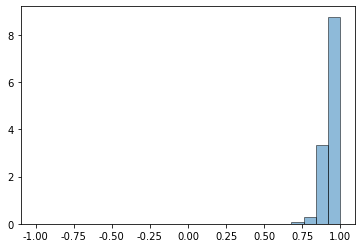

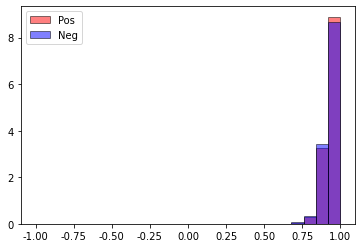

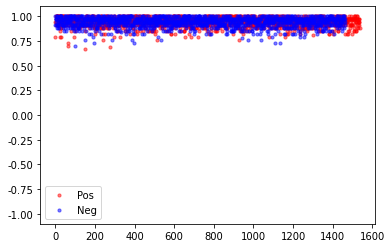

In [14]:
from model import FeatureErasureABS
FeatureErasureABS(model,test_batch,test_labels,'TanhMax')

### Exp4--Attention Permutation

3000it [02:13, 22.51it/s]


Both label
	total num: 3000  mean: 0.07980889  std: 0.034229636
Pos
	total num: 1537  mean: 0.08925646  std: 0.030044576
Neg
	total num: 1463  mean: 0.06988346  std: 0.035524353


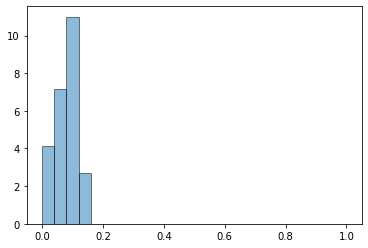

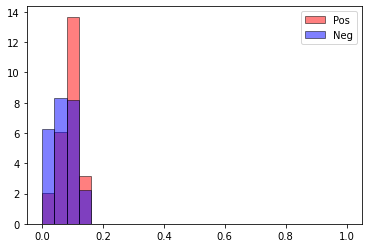

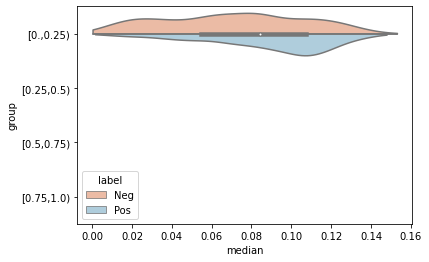

                 median                                                    \
                  count      mean       std       min       25%       50%   
label group                                                                 
Neg   [0.,0.25)  1463.0  0.069883  0.035537  0.000194  0.039859  0.070891   
Pos   [0.,0.25)  1537.0  0.089256  0.030054  0.001472  0.070853  0.096245   

                                     
                      75%       max  
label group                          
Neg   [0.,0.25)  0.098262  0.153016  
Pos   [0.,0.25)  0.111081  0.147797  


In [15]:
from model import AttnPermutation
AttnPermutation(model,test_batch,test_labels,'TanhMax')

### Exp5--Attention Randomization

3000it [02:22, 20.98it/s]


Both label
	total num: 3000  mean: 0.46038127  std: 0.25531512
Pos
	total num: 1537  mean: 0.47989818  std: 0.31599575
Neg
	total num: 1463  mean: 0.4398772  std: 0.16716518


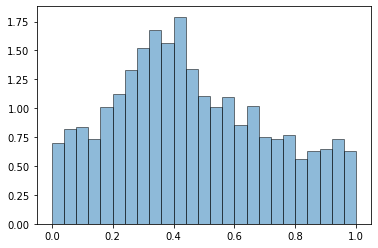

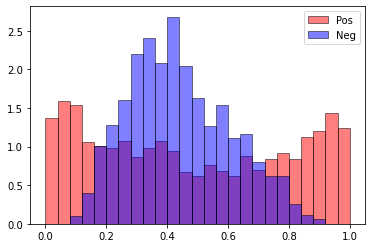

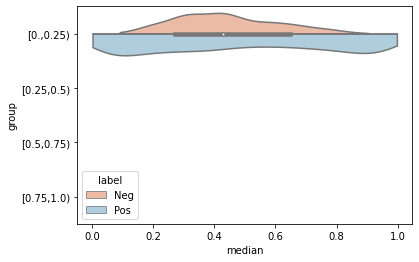

                 median                                                    \
                  count      mean       std       min       25%       50%   
label group                                                                 
Neg   [0.,0.25)  1463.0  0.439877  0.167222  0.091278  0.312959  0.421861   
Pos   [0.,0.25)  1537.0  0.479898  0.316099  0.002589  0.187799  0.442744   

                                     
                      75%       max  
label group                          
Neg   [0.,0.25)  0.560768  0.903220  
Pos   [0.,0.25)  0.780404  0.997017  


In [16]:
from model import AttnRandom
AttnRandom(model,test_batch,test_labels,'TanhMax')